# Tutorial to Generate Ambient Contamination Metric Plots

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from matplotlib import pyplot as plt
import dropkick 

In [2]:
sys.path.append("/home/lucy/STAR_Protocol/")

import quality_control_function as qc
import plot_quality_score as qc_plts


## Step1: cut-off datasets so that the number of barcodes included in the analysis scales with the estimated real cell number 

### Option 1: Read dropset data (gene names, barcodes and count matrix) into an anndata object and cut-off the anndata object
- need to cut off the dataset because there will usually be a large and varied number of empty droplets in each dataset
- set the barcode size to 4* inflection point is a recommanded choice
- inflection point found by a QCPipe function, supposed to be an estimate cut line distinguishing between empty droplets and real cells based on total transcript counts

In [ ]:
#specify the directory where the data stores 
dat_path = "/home/lucy/random_data_check/data_files/5898_YX_10/"

/home/lucy/random_data_check/data_files/5898_YX_10//*features.*
Calculating QC Metrics
Inflection point at [ 3176  7168 11160] for [0, 15, 30] percentiles of greatest secant distances
the original dataset has 29791 cells. Cut to 10000 cells


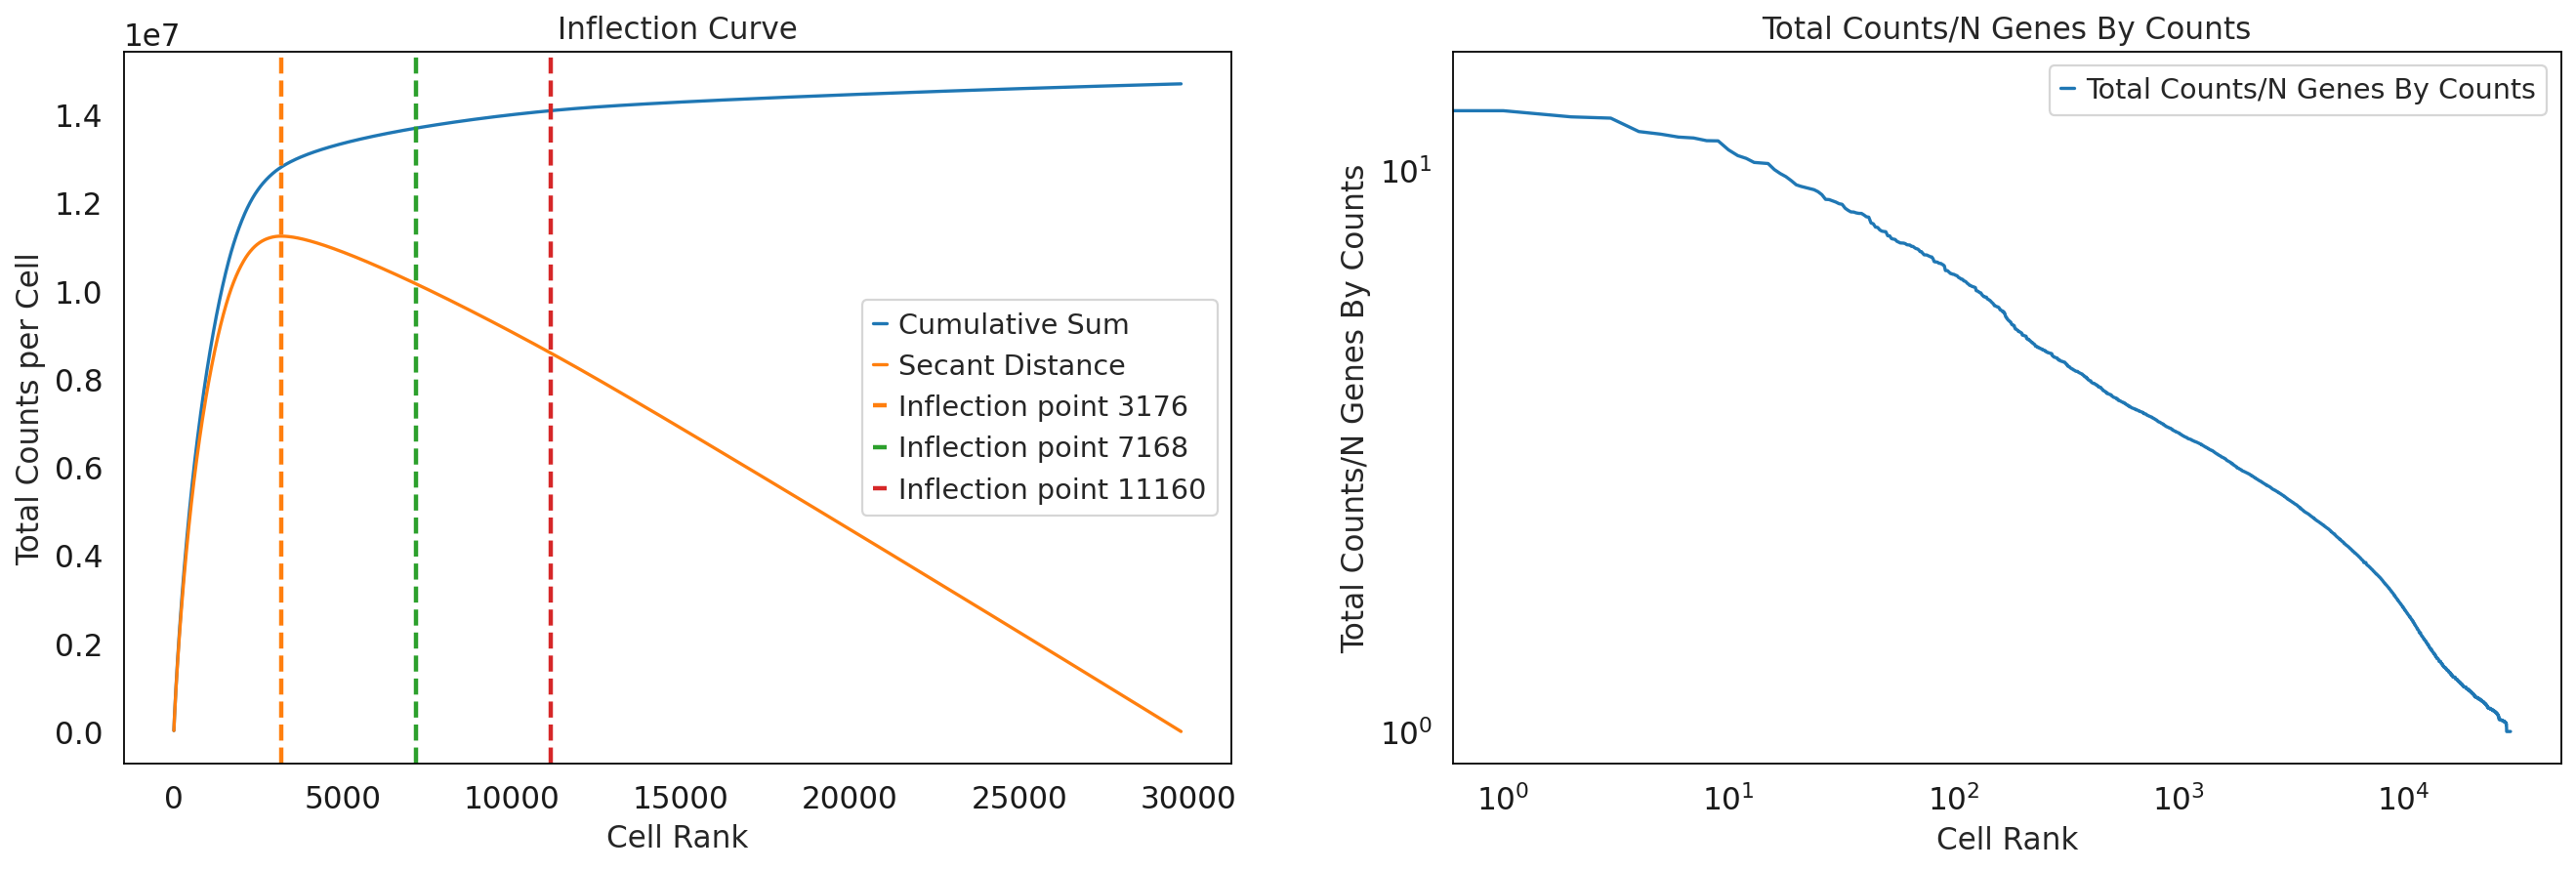

In [10]:
# identifiers are keywords naming the gene and barcode files in the dropset folder
# delim (delimiter) as specified in pandas' read_csv function ('\t' for tsv, ',' for csv)
# var/obs col need to be set if the featre/gene name or barcode file has more than one columns
# eg. gene name files some times consist of ensembl ID and gene name in 2 columns 
# in this case, set the number as the column number to be used 

# max_cell number is the hard cut-off: always keep no more than that number 
# regardless of inflection point or estimate real cell number

# inflection points will be calculated as an estimated real cell number 
# cut-off will be set to inflection_fold * the inflection point 
#if est_real_cell set, the cut-off will be set to inflection_fold * est_real_cell 
#instead of the computed inflection point

#for more detail, read the function header 
dat = qc.cut_off_from_dropset( data_path = dat_path, 
                         gene_file_identifier = "features", barcode_file_identifier = "barcodes",
                         gene_file_delim = ',', barcode_file_delim = ',',
                         var_col = 0, obs_col = 0, 
                         inflection_fold = 4, est_real_cell= None, max_cell = 10000, 
                         mito_tag = "MT-",run_qc=True, print_info = True)


In [11]:
#check if read-in properly 
dat.to_df().head()

Genes,FO538757.1,RP5-857K21.4,MIR6723,ISG15,SDF4,RP11-465B22.8,ACAP3,GNB1,CDK11B,RER1,...,CXCR2,CCL16,TP53AIP1,RP11-461F11.2,RP11-205K6.1,CTD-2309H9.3,RP11-738B7.1,RP11-459J23.1,RP11-568A19.1,RP11-308K2.1
Cells,,,,,,,,,,,,,,,,,,,,,
AGGTGACACGTGGAGCT,1.0,1018.0,1.0,0.0,4.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAGGCGTTAGTTAGGACC,1.0,1222.0,0.0,0.0,6.0,0.0,0.0,5.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAATTGGGCCGTCCATGT,1.0,1492.0,2.0,0.0,11.0,2.0,0.0,8.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGAACATCTATGCAACCTG,1.0,1874.0,2.0,0.0,3.0,1.0,0.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAGTCGCAATATCTTC,3.0,1070.0,0.0,0.0,7.0,1.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating QC Metrics


OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Inflection point at [ 3176  7168 11160] for [0, 15, 30] percentiles of greatest secant distances
the original dataset has 29791 cells. Cut to 12000 cells


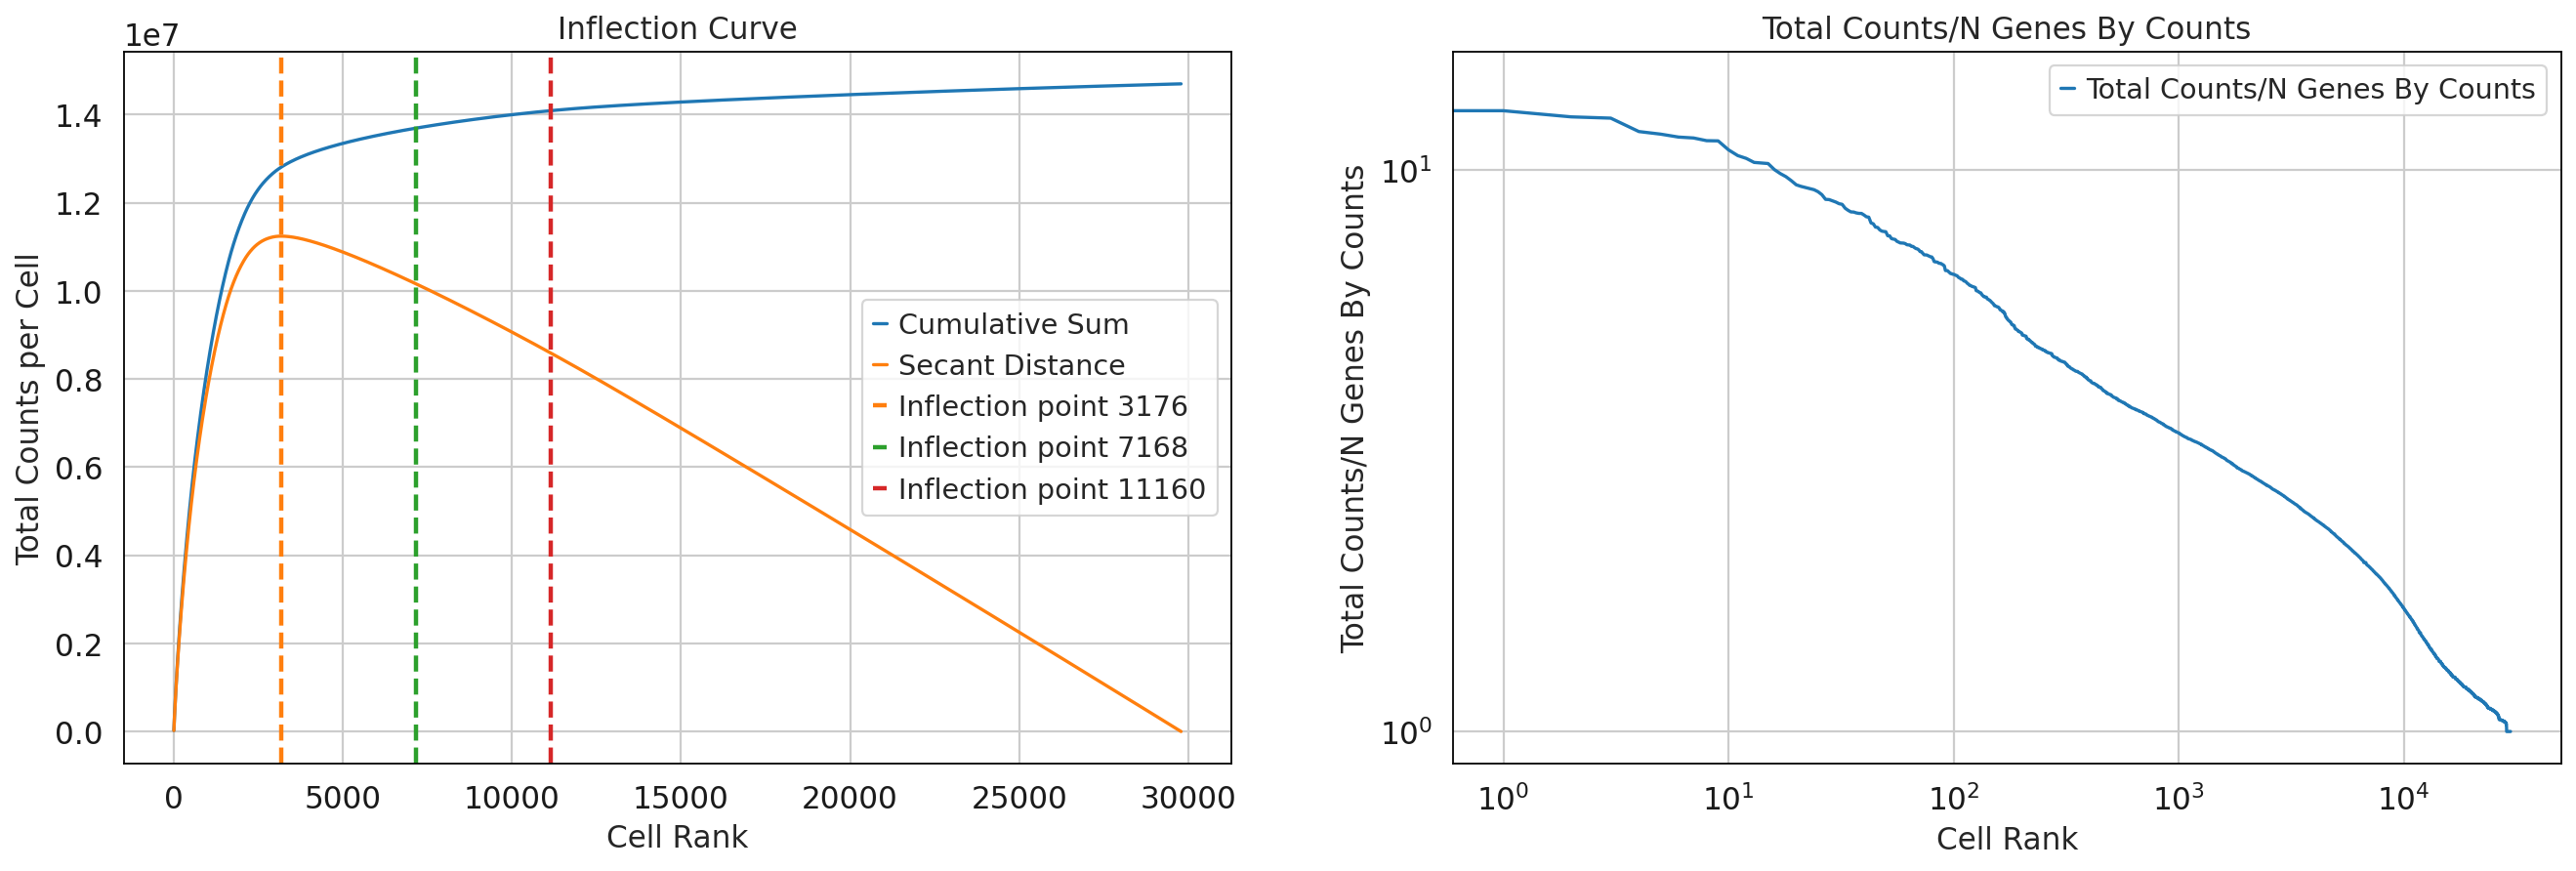

In [5]:
# max_cell number is the hard cut-off: always keep no more than that number 
# regardless of inflection point or estimate real cell number

# inflection points will be calculated as an estimated real cell number 
# cut-off will be set to inflection_fold * the inflection point 
#if est_real_cell set, the cut-off will be set to inflection_fold * est_real_cell 
#instead of the computed inflection point



### Option 2: Cut-off from pre-filtered h5ad files

In [ ]:
dat = sc.read("/home/lucy/random_data_check/data_files/5898_YX_10_full.h5ad")

In [ ]:
dat2 = qc.cut_off_h5ad(dat, inflection_fold = 4, est_real_cell = None, max_cell = 12000, 
                 qc_pipe_inflection = True, mito_tag = "MT-",run_qc=True, 
                 print_info = True)

## Step2: Generate the metric plots

Trying to set attribute `.var` of view, copying.


mean_end_grad: 0.0001873773871921003
slope freq high slope ratio: 0.24339006360969506
Top 3 ambient genes have dropout rates between 0.092 and 0.325 percent:
	['MT-RNR2', 'RP5-857K21.4', 'MT-CO3']


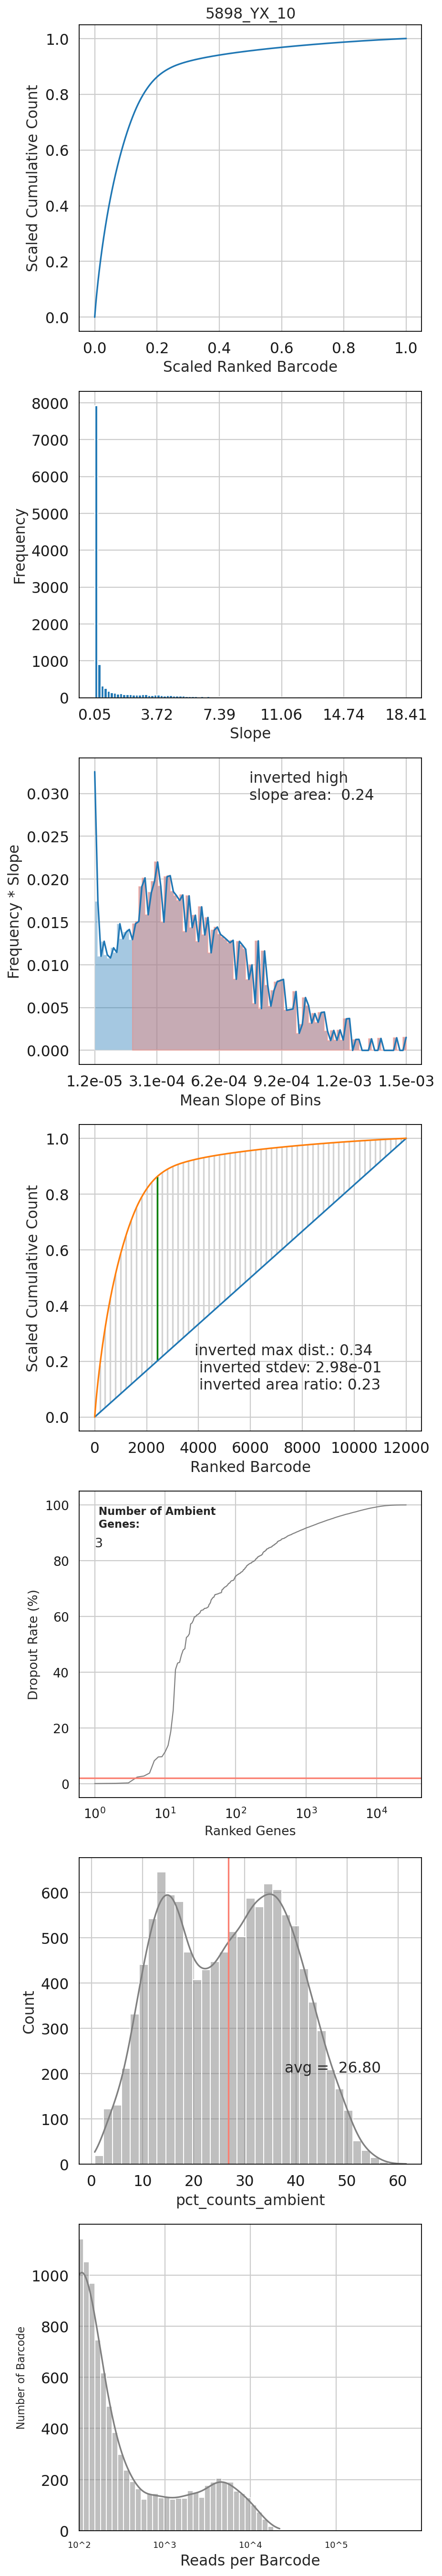

In [6]:
ret = qc_plts.formatted_figures_one_column_inverted(dat2, save_amb_ls = None, 
                      save_fig = None, show_dat_name = "5898_YX_10", 
                      slope_freq_mode = -1, invert_scores = True)

#### the function also return the numerical results that can be saved in csv or for other use

In [14]:
ret[0:-1]
#[inverted high slope area, 
# inverted max_secant, 
# inverted std_val, 
# inverted cum_curve_area_ratio, 
# number of ambient genes,
# mean pct_count_ambient ] 

[0.24339006360969506,
 0.3379686783999205,
 0.2977118010211993,
 0.2291204575306247,
 3,
 26.796093]

TODO:
- describe interpretation of the plots and metric values 
- make the plotting format more flexible 
- deposit a file for public to follow
- add more description to make each step user friendly to follow